# Comparison of all perturbations
Use extracted features to build per-cell representations and analyse similarity of perturbations with them
- plot UMAP
- calculate distance of perturbartions 

In [20]:
from miann.constants import EXPERIMENT_DIR
from miann.data import MPPData
from miann.tl import Experiment
from miann.tl import Cluster, FeatureExtractor
from miann.tl._cluster import add_clustering_to_adata
from miann.pl import annotate_img
from miann.utils import init_logging
import os
import numpy as np
import scanpy as sc
import seaborn as sns
import pandas as pd
import anndata as ad
import squidpy as sq
from sklearn.metrics import silhouette_score
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
init_logging()

In [2]:
def add_perturbation_plot(adata):
    # create perturbation_plot column from perturbation_duration column
    p = np.array(adata.obs['perturbation_duration'])
    p[p == 'AZD4573-120'] = 'AZD4573 (2h)'
    p[p == 'AZD4573-30'] = 'AZD4573 (0.5h)'
    p[p == 'CX5461-120'] = 'CX5461 (2h)'
    p[p == 'Meayamycin-720'] = 'Meayamycin (12h)'
    p[p == 'TSA-30'] = 'TSA (0.5h)'
    p[p == 'Triptolide-120'] = 'Triptolide (2h)'
    p[np.in1d(p, ['DMSO-120', 'DMSO-720', 'normal'])] = 'unperturbed'
    adata.obs['perturbation_plot'] = p
    adata.obs['perturbation_plot'] = adata.obs['perturbation_plot'].astype('category')

In [3]:
os.makedirs('fig3', exist_ok=True)
#os.makedirs('fig1_suppl', exist_ok=True)

In [109]:
from numba import jit, njit
#from scipy.spatial.distance import cityblock

@njit
def cityblock(a,b,w=None):
    if w is None:
        w = np.ones_like(a)
    return np.mean(np.abs(a-b)*w)

def calc_co_occ_knn(adata, cluster_pairs=None, key_added='co_occurrence'):
    """
    Calculate knn graph using co_occurrence scores.

    Args:
        adata: concatenated feature adata containing co_occurrence scores in adata.obsm
        cluster_pairs: list of cluster tuples that should be used to calculate neighborhood graph. 
            If none, all available cluster pairs are used

    adds 
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if cluster_pairs is None:
        cluster_pairs = [(c1, c2) for c1 in adata.uns['clusters'] for c2 in adata.uns['clusters']]
    co_occ_keys = [f'co_occurrence_{c1}_{c2}' for c1, c2 in cluster_pairs]

    # build combined co-occ matrix
    arr = np.concatenate([adata.obsm[k] for k in co_occ_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr

    # weights to use for l1 distance
    distances = (adata.uns['co_occurrence_params']['interval'][:-1] + adata.uns['co_occurrence_params']['interval'][1:]) / 2
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric=cityblock, metric_kwds={'w': np.tile(distances/np.mean(distances), len(cluster_pairs))}, key_added=key_added)

def calc_intensity_knn(adata, clusters=None, key_added='intensity'):
    """
    Calculate knn graph using mean cluster intensity.

    Args:
        adata: concatenated feature adata containing intensity scores in adata.obsm
        clusters: list of cluster names that should be used to calculate neighborhood graph.
            If none, all available cluster pairs are used.

    adds
    - adata.obsm[key_added] containing representation used for calculating neighborhood graph
    - adata.obsp[key_added_connectivities] neighborhood graph representation
    """
    # pick cluster pairings to include in co-occ neighborhood graph
    if clusters is None:
        clusters = adata.uns['clusters']
    intensity_keys = [f'intensity_{c}' for c in clusters]
    
    # build combined intensity matrix
    arr = np.concatenate([adata.layers[k] for k in intensity_keys], axis=1)
    # replace nans with 0
    arr[np.isnan(arr)] = 0
    adata.obsm[key_added] = arr
    
    # calculate knn graph
    sc.pp.neighbors(adata, use_rep=key_added, n_pcs=0, metric=cityblock, key_added=key_added)

## Load data

In [4]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

# get combined adata
adata = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')
add_perturbation_plot(adata)

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster dat

## Calculate knn based on intensity and co-occ scores

In [102]:
calc_co_occ_knn(adata, key_added='co_occurrence')
adata.obsm['X_co_occurrence_umap'] = sc.tl.umap(adata, neighbors_key='co_occurrence', copy=True).obsm['X_umap']

In [103]:
calc_intensity_knn(adata, key_added='intensity')
adata.obsm['X_intensity_umap'] = sc.tl.umap(adata, neighbors_key='intensity', copy=True).obsm['X_umap']

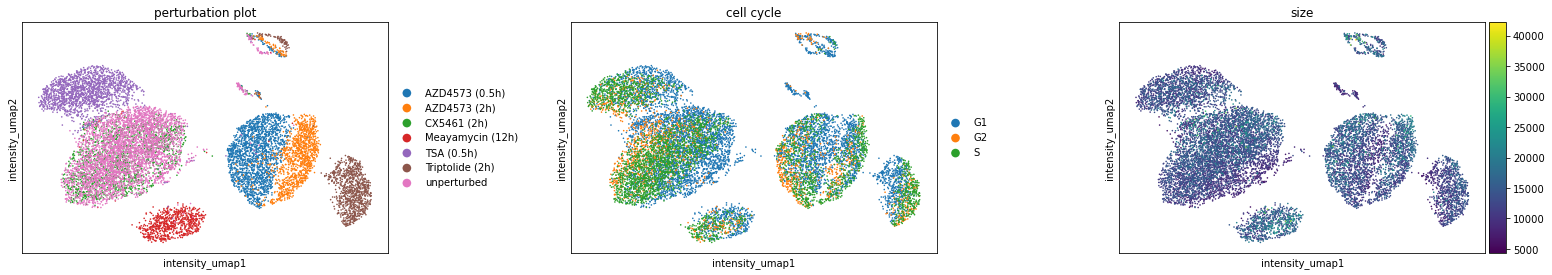

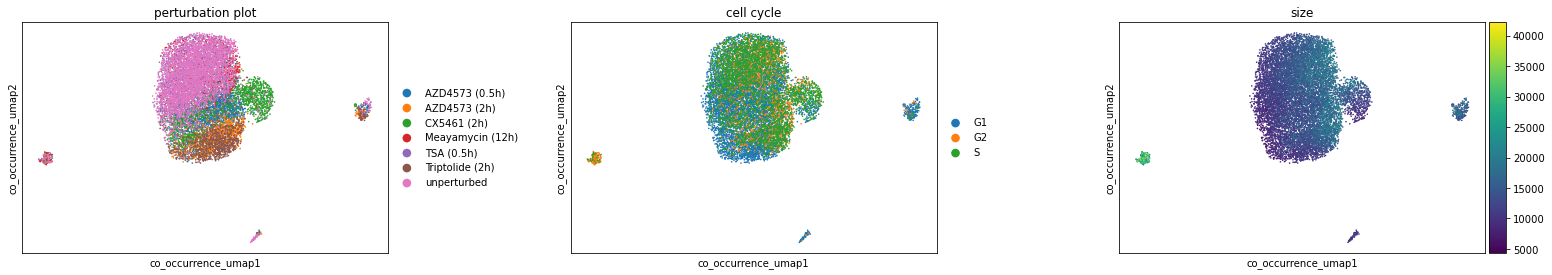

In [104]:
adata.obs['size'] = adata.obsm['size']['all']
sc.pl.scatter(adata, basis='intensity_umap', color=['perturbation_plot', 'cell_cycle', 'size'])
sc.pl.scatter(adata, basis='co_occurrence_umap', color=['perturbation_plot', 'cell_cycle', 'size'])

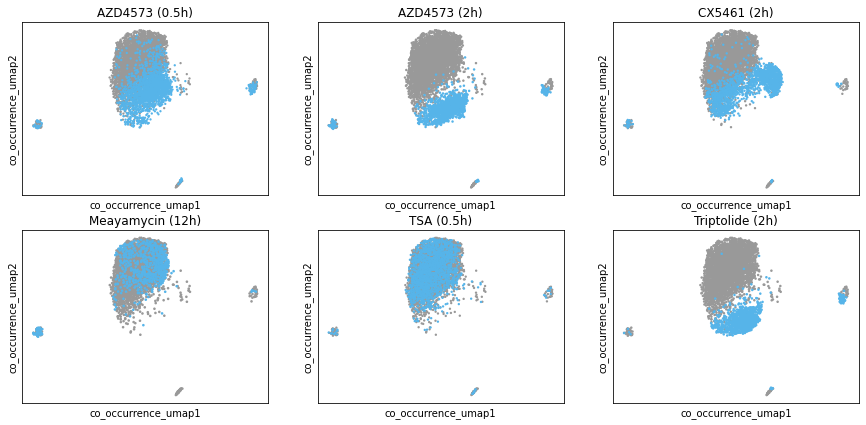

In [105]:
fig, axes = plt.subplots(2,3, figsize=(15,7))
i = 0
for p in adata.obs['perturbation_plot'].cat.categories:
    if p == 'unperturbed':
        continue
    ax = axes.flat[i]
    i += 1
    tmp = adata[adata.obs['perturbation_plot'].isin(['unperturbed', p])]
    tmp.obs[p] = (tmp.obs['perturbation_plot'] == p).astype('category')
    tmp.uns[f'{p}_colors'] = ["#999999", "#56B4E9"]
    
    sc.pl.scatter(tmp, color=p, basis='co_occurrence_umap', ax=ax, show=False, legend_loc='none')

In [106]:
# calculate neighbohood enrichment
zscore_co_occ, count_co_occ = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                                     connectivity_key='co_occurrence', n_perms=1000, 
                                                     numba_parallel=False, copy=True)
zscore_intensity, count_intensity = sq.gr.nhood_enrichment(adata, cluster_key='perturbation_plot', 
                                                           connectivity_key='intensity', n_perms=1900, 
                                                           numba_parallel=False, copy=True)

100%|██████████| 1900/1900 [00:01<00:00, 1150.51/s]


In [114]:
# calculate silhouette score
from sklearn.metrics import silhouette_score

cond_key = 'perturbation_plot'

# co-occurrence
siscore_co_occ = np.zeros([len(adata.obs[cond_key].cat.categories)]*2)
distances = (adata.uns['co_occurrence_params']['interval'][:-1] + adata.uns['co_occurrence_params']['interval'][1:]) / 2
distances = np.tile(distances/np.mean(distances), int(adata.obsm['co_occurrence'].shape[1] / len(distances))).astype(np.float64)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        print(i,j)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        siscore_co_occ[i,j] = silhouette_score(adata_sub.obsm['co_occurrence'], labels=adata_sub.obs[cond_key], metric=cityblock, w=distances)
        siscore_co_occ[j,i] = siscore_co_occ[i,j]

# intensity
siscore_intensity = np.zeros([len(adata.obs[cond_key].cat.categories)]*2)
for i,c1 in enumerate(adata.obs[cond_key].cat.categories):
    for j,c2 in enumerate(adata.obs[cond_key].cat.categories):
        if j <= i:
            continue
        print(i,j)
        adata_sub = adata[adata.obs[cond_key].isin([c1,c2])]
        siscore_intensity[i,j] = silhouette_score(adata_sub.obsm['intensity'], labels=adata_sub.obs[cond_key], metric=cityblock)
        siscore_intensity[j,i] = siscore_intensity[i,j]

0 1
0 2
0 3
0 4
0 5
0 6
1 2
1 3
1 4
1 5
1 6
2 3
2 4
2 5
2 6
3 4
3 5
3 6
4 5
4 6
5 6
0 1
0 2
0 3
0 4
0 5
0 6
1 2
1 3
1 4
1 5
1 6
2 3
2 4
2 5
2 6
3 4
3 5
3 6
4 5
4 6
5 6


Text(0.5, 1.0, 'silhouette intensity')

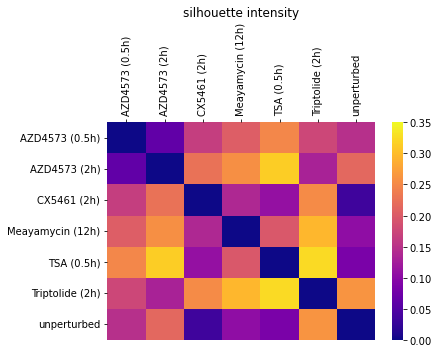

In [115]:
# plot nhood enrichment scores
fig, ax = plt.subplots(1,1)
sns.heatmap(siscore_intensity, vmin=0, vmax=0.35, cmap='plasma')

ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
ax.xaxis.set_ticks_position('top')
ax.set_title('silhouette intensity')

Text(0.5, 1.0, 'nhood enrichment intensity -1*zscore (larger = more dissimilar)')

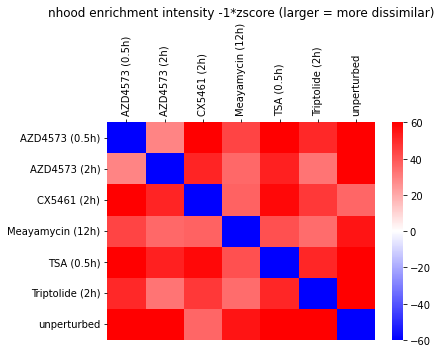

In [116]:
# plot nhood enrichment scores
fig, ax = plt.subplots(1,1)
sns.heatmap(zscore_intensity*-1, vmin=-60, vmax=60, cmap='bwr')

ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
ax.xaxis.set_ticks_position('top')
ax.set_title('nhood enrichment intensity -1*zscore (larger = more dissimilar)')

Text(0.5, 1.0, 'silhouette co occ')

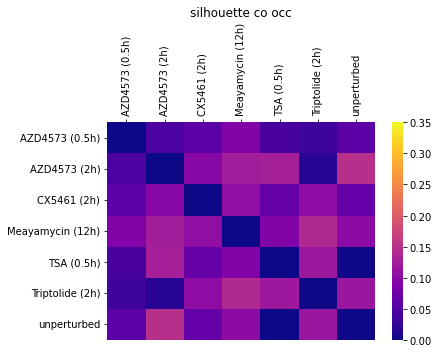

In [117]:
# plot nhood enrichment scores
fig, ax = plt.subplots(1,1)
sns.heatmap(siscore_co_occ, vmin=0, vmax=0.35, cmap='plasma')

ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
ax.xaxis.set_ticks_position('top')
ax.set_title('silhouette co occ')

Text(0.5, 1.0, 'nhood enrichment co occ -1*zscore (larger = more dissimilar)')

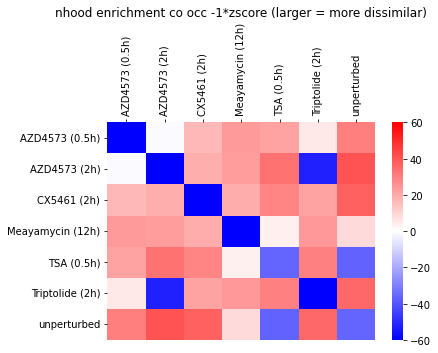

In [75]:
fig, ax = plt.subplots(1,1)
sns.heatmap(zscore_co_occ*-1, vmin=-60, vmax=60, cmap='bwr')

ax.set_xticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=90)
ax.set_yticklabels(adata.obs['perturbation_plot'].cat.categories, rotation=0)
ax.xaxis.set_ticks_position('top')
ax.set_title('nhood enrichment co occ -1*zscore (larger = more dissimilar)')

In [6]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad')) 
    for data_dir in exp.data_params['data_dirs']}

INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster data in aggregated/sub-0.001
INFO:Experiment:Setting up experiment VAE_all/CondVAE_pert-CC
INFO:Experiment:Initialised from existing experiment in VAE_all/CondVAE_pert-CC
INFO:Experiment:Cluster annotation: using cluster dat

In [4]:
exp_name = 'VAE_all/CondVAE_pert-CC'
cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.001')
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# geta adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name('clustering_res0.5') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.5', adata, cl.cluster_annotation)
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.5', adata, cl.cluster_annotation, annotation_col='annotation')
# create perturbation names to plot
add_perturbation_plot(adata)

INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
INFO:MPPData:Loaded data from VAE_all/CondVAE_pert-CC/aggregated/sub-0.001.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (154906 mpps with shape (3, 3, 34) from 11847 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'clustering_res0.5', 'umap'].
